In [28]:
# import boto3
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [3]:
germany_df = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', index_col='LNR')
customers_df = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', index_col='LNR')
train_df = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', index_col='LNR')
test_df = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';', index_col='LNR')
metadata = pd.read_csv('data/metadata.csv')
print(germany_df.shape)

/Users/richard.wuebker/.pyenv/versions/science/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(891221, 365)


In [4]:
metadata.head()

,feature_name,type,unknown_neg_one,unknown_zero,unknown_nine,zero_none,needs_reverse,keep
0,AGER_TYP,ordinal,1,1,0,0,0,1
1,ALTERSKATEGORIE_GROB,ordinal,1,1,1,0,0,1
2,ALTER_HH,ordinal,0,1,0,0,0,1
3,ANREDE_KZ,categorical,1,1,0,0,0,1
4,ANZ_HAUSHALTE_AKTIV,ordinal,0,0,0,0,0,1


In [9]:
CAMEO_DEU_2015_MAP = {
    '1A': 1,
    '1B': 1,
    '1C': 1,
    '1D': 1,
    '1E': 1,
    '2A': 2,
    '2B': 2,
    '2C': 2,
    '2D': 2,
    '3A': 3,
    '3B': 3,
    '3C': 3,
    '3D': 3,
    '4A': 4,
    '4B': 4,
    '4C': 4,
    '4D': 4,
    '4E': 4,
    '5A': 5,
    '5B': 5,
    '5C': 5,
    '5D': 5,
    '5E': 5,
    '5F': 5,
    '6A': 6,
    '6B': 6,
    '6C': 6,
    '6D': 6,
    '6E': 6,
    '6F': 6,
    '7A': 7,
    '7B': 7,
    '7C': 7,
    '7D': 7,
    '7E': 7,
    '8A': 8,
    '8B': 8,
    '8C': 8,
    '8D': 8,
    '9A': 9,
    '9B': 9,
    '9C': 9,
    '9D': 9,
    '9E': 9
}

PRAEGENDE_JUGENDJAHRE_MAP = {
    1: 0,
    2: 1,
    3: 0,
    4: 1,
    5: 0,
    6: 1,
    7: 1,
    8: 0,
    9: 1,
    10: 0,
    11: 1,
    12: 0,
    13: 1,
    14: 0,
    15: 1
}

In [11]:
def reverse_order(val, mx, mn):
    diff_from_low = val - mn 
    return mx - diff_from_low


def default_clean(df, drop_threshold=20, testing=False):
    df_ = df.copy()
    
    print('initial df shape: ', df_.shape)
    keep_features = list(metadata[metadata['keep'] == 1]['feature_name'])
    if 'RESPONSE' in df.columns:
        keep_features.append('RESPONSE')
    df_ = df_[keep_features]
    
    filter_ = df_['CAMEO_DEUG_2015'] != np.nan
    df_.loc[filter_, 'CAMEO_DEUG_2015'] = pd.to_numeric(df_.loc[filter_, 'CAMEO_DEUG_2015'], errors='coerce')
    
    # set zero to negative one where zero means unknown
    unknown_zero_features = list(metadata[metadata['unknown_zero'] == 1]['feature_name'])
    for feature in unknown_zero_features:
        df_.loc[df_[feature] == 0, feature] = -1
        
    # set nine to negative one where nine means unknown
    unknown_nine_features = list(metadata[metadata['unknown_nine'] == 1]['feature_name'])
    for feature in unknown_nine_features:
        df_.loc[df_[feature] == 9, feature] = -1
        
        
    # special cases
    df_['CAMEO_DEUG_2015'].replace('X', np.nan, inplace=True)
    #df_['OST_WEST_KZ'].replace('O', 1, inplace=True)
    #df_['OST_WEST_KZ'].replace('W', 0, inplace=True)    
    df_['CAMEO_DEU_2015'] = df_['CAMEO_DEU_2015'].apply(lambda x: x if x in CAMEO_DEU_2015_MAP else np.nan)
    df_['PRAEGENDE_JUGENDJAHRE'] = df_['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: PRAEGENDE_JUGENDJAHRE_MAP[x] if x in PRAEGENDE_JUGENDJAHRE_MAP else np.nan)
    
    # set -1 (unknown) to np.nan
    df_ = df_.replace(-1, np.nan)
    
    
    # change some numerical columns to categorical for one hot encoding:
    cat_cols = list(metadata.loc[(metadata['type'] == 'categorical') & (metadata['keep'] == 1), 'feature_name'])
    print('cat_cols: ', cat_cols)
    for col in cat_cols:
        if col in df_.columns:
            df_[col] = np.where(df_[col].isnull(), df_[col], df_[col].astype('str'))

    df_ = pd.get_dummies(df_, prefix=cat_cols, columns=cat_cols)
    
    
    # reverse some cols so higher number = higher feature
    reverse_cols = list(metadata.loc[metadata['needs_reverse']==1, 'feature_name'])
    for col in reverse_cols:
        if col in df_.columns:
            series = df_[col]
            df_[col] = df_[col].apply(reverse_order, args=(np.max(series), np.min(series)))
            
            
    percent_missing = df_.isnull().sum() * 100 / len(df)
    mv_df = pd.DataFrame({'column_name': df_.columns, 'percent_missing': percent_missing})
    mv_cols = mv_df.loc[mv_df['percent_missing'] > drop_threshold]['column_name']    
    df_ = df_.drop(list(mv_cols), axis=1)
    
    # choosing not to drop rows
    if False:
        
        grouped = df_.groupby(df_.RESPONSE)
        pos = grouped.get_group(1)
        neg = grouped.get_group(0)
        neg = neg.dropna(thresh=thresh)
        df_  = neg.append(pos, verify_integrity=True, ignore_index=False)
        
        
    #df_ = df_.loc[:, ~df_.columns.str.startswith('KB')]
    
    print('new df shape: ', df_.shape)
    
    return df_

In [23]:
clean_g_data = default_clean(germany_df, drop_threshold=30)
print(clean_g_data.shape)
clean_c_data = default_clean(customers_df, drop_threshold=30)
print(clean_c_data.shape)

train_df_init = default_clean(train_df, drop_threshold=30)
test_df_init = default_clean(test_df, drop_threshold=30)

initial df shape:  (891221, 365)
cat_cols:  ['ANREDE_KZ', 'CAMEO_DEU_2015', 'D19_KONSUMTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'KBA05_SEG6', 'KONSUMNAEHE', 'NATIONALITAET_KZ', 'OST_WEST_KZ', 'PRAEGENDE_JUGENDJAHRE', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP']
new df shape:  (891221, 374)
(891221, 374)
initial df shape:  (191652, 368)
cat_cols:  ['ANREDE_KZ', 'CAMEO_DEU_2015', 'D19_KONSUMTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'KBA05_SEG6', 'KONSUMNAEHE', 'NATIONALITAET_KZ', 'OST_WEST_KZ', 'PRAEGENDE_JUGENDJAHRE', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP']
new df shape:  (191652, 370)
(191652, 370)
initial df shape:  (42962, 366)
cat_cols:  ['ANREDE_KZ', 'CAMEO_DEU_2015', 'D19_KONSUMTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'KBA05_H

In [26]:
def get_initial_sets():


    inter_cols = list(set.intersection(set(clean_g_data.columns), set(clean_c_data.columns), set(train_df_init), 
                                       set(test_df_init.columns))) 

    clean_g_full = clean_g_data[inter_cols]

    # "Cardinality" means the number of unique values in a column
    # Select categorical columns with relatively low cardinality (convenient but arbitrary)
    categorical_cols = [cname for cname in clean_g_full.columns if
                        clean_g_full[cname].nunique() < 15 and
                        clean_g_full[cname].nunique() >= 2 and
                        clean_g_full[cname].dtype == "object"]


    # Select numerical columns
    numerical_cols = [cname for cname in clean_g_full.columns if 
                    clean_g_full[cname].dtype in ['int64', 'float64', 'uint8']]
    

    # Keep selected columns only
    my_cols = numerical_cols + categorical_cols

    # supervised testing and full datasets
    X_test = test_df_init[my_cols].copy()
    X_total_train = train_df_init[my_cols].copy()
    y_total_train = train_df_init['RESPONSE'].copy()
    clean_g = clean_g_data[my_cols].copy()
    clean_c = clean_c_data[my_cols].copy()

    assert(list(X_total_train.columns) == list(X_test.columns) == list(clean_g.columns) == list(clean_c.columns))
    
    return clean_g, clean_c, X_total_train, y_total_train, X_test, numerical_cols, categorical_cols

In [29]:
clean_g, clean_c, X_total_train, y_total_train, X_test, numerical_cols, categorical_cols = get_initial_sets()

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
   # ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

[]


In [32]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor)
                     ])

imputed_g = pd.DataFrame(my_pipeline.fit_transform(clean_g), index=clean_g.index, columns=clean_g.columns)
imputed_c = pd.DataFrame(my_pipeline.transform(clean_c), index=clean_c.index, columns=clean_c.columns)
imputed_train = pd.DataFrame(my_pipeline.transform(X_total_train), index=X_total_train.index, columns=X_total_train.columns)
imputed_test = pd.DataFrame(my_pipeline.transform(X_test), index=X_test.index, columns=X_test.columns)

In [33]:
imputed_train.describe()

,KBA13_VORB_2,KBA13_BJ_2004,D19_GESAMT_ANZ_12,KBA05_CCM4,D19_KONSUMTYP_2.0,KBA13_FIAT,KBA13_CCM_0_1400,KBA05_MAXHERST_1.0,TITEL_KZ_3.0,KBA05_ALTER2,...,KBA13_KRSSEG_VAN,NATIONALITAET_KZ_1.0,FINANZTYP,KBA13_SEG_GROSSRAUMVANS,D19_KONSUMTYP_1.0,CAMEO_DEU_2015_3C,KBA05_KRSAQUOT,KBA13_SEG_SONSTIGE,KBA05_MAXVORB,GEBAEUDETYP_RASTER_2.0
count,42962.000000,42962.000000,42962.000000,42962.00000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,...,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000,42962.000000
mean,0.488556,0.507415,0.159269,0.31355,0.139356,0.524582,0.451527,0.092361,0.000116,0.468676,...,0.652906,0.801266,0.345906,0.524551,0.180392,0.036009,0.542559,0.512277,0.487309,0.048159
std,0.214268,0.215512,0.237569,0.26552,0.346321,0.230245,0.259789,0.289538,0.010788,0.226521,...,0.182690,0.399052,0.333689,0.233786,0.384518,0.186314,0.243169,0.214601,0.323537,0.214104
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.495705,0.000000,0.00000,0.000000,0.500000,0.400000,0.000000,0.000000,0.250000,...,0.648434,1.000000,0.000000,0.500000,0.000000,0.000000,0.495091,0.500000,0.500000,0.000000
50%,0.500000,0.500000,0.000000,0.25000,0.000000,0.500000,0.468486,0.000000,0.000000,0.500000,...,0.666667,1.000000,0.200000,0.500000,0.000000,0.000000,0.500000,0.500000,0.500000,0.000000
75%,0.502774,0.500000,0.333333,0.50000,0.000000,0.750000,0.600000,0.000000,0.000000,0.508251,...,0.666667,1.000000,0.800000,0.750000,0.000000,0.000000,0.750000,0.517860,0.541663,0.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
NUM_COMPONENTS = 200
pca = PCA(n_components=NUM_COMPONENTS)
pca.fit(imputed_g)
print(np.sum(pca.explained_variance_ratio_))

0.949718551331318


In [44]:
np.sum(pca.explained_variance_ratio_[:151])

0.9000948066904257

In [45]:
features_list = list(imputed_g.columns)
len(features_list)

370

In [47]:
feature_weights = pca.components_
w_df = pd.DataFrame(feature_weights, columns=imputed_g.columns)
w_df.tail()

,KBA13_VORB_2,KBA13_BJ_2004,D19_GESAMT_ANZ_12,KBA05_CCM4,D19_KONSUMTYP_2.0,KBA13_FIAT,KBA13_CCM_0_1400,KBA05_MAXHERST_1.0,TITEL_KZ_3.0,KBA05_ALTER2,...,KBA13_KRSSEG_VAN,NATIONALITAET_KZ_1.0,FINANZTYP,KBA13_SEG_GROSSRAUMVANS,D19_KONSUMTYP_1.0,CAMEO_DEU_2015_3C,KBA05_KRSAQUOT,KBA13_SEG_SONSTIGE,KBA05_MAXVORB,GEBAEUDETYP_RASTER_2.0
195,-0.011453,0.024882,0.056340,0.108819,-0.016066,0.010611,-0.055256,-0.011123,1.173508e-04,0.059193,...,-0.012767,-0.000801,0.026464,0.033444,-0.035612,-0.048421,0.002720,-0.045267,0.167405,-0.014541
196,0.043009,0.004648,-0.040623,-0.041234,-0.007270,-0.081616,-0.013799,0.008444,-1.820749e-04,-0.019320,...,-0.005689,-0.002593,-0.017924,0.015614,0.014031,0.032342,-0.012355,0.055636,-0.017803,0.035869
197,0.023710,0.000911,-0.098375,0.000621,0.011936,0.061503,0.009945,-0.002674,7.577780e-07,-0.010287,...,0.003055,-0.005430,-0.023305,-0.049967,0.057361,-0.013263,-0.012082,-0.091193,0.038551,-0.012443
198,0.049914,0.021988,0.083880,-0.019774,-0.004873,-0.098990,-0.050598,0.000417,2.069148e-04,0.016886,...,-0.038568,-0.003587,0.015303,0.087372,-0.039853,-0.012244,0.001135,0.087453,-0.004771,-0.011263
199,0.023823,0.000905,-0.020866,-0.053622,0.002273,-0.034256,-0.037839,-0.010516,1.536747e-04,0.009865,...,0.016737,-0.000752,-0.001723,-0.036456,0.018350,-0.039477,-0.001880,0.043793,0.083363,0.026273


In [48]:
def display_component(v, features_list, component_num, n_weights=10):
    v_1_row = v.iloc[component_num, :]
    v_1 = np.squeeze(v_1_row.values)
    weights = pd.DataFrame(list(zip(v_1, features_list)), columns=['weight', 'feature'])
    weights['abs_weight'] = weights['weight'].apply(lambda x: np.abs(x))
    sorted_weight_data = weights.sort_values('abs_weight', ascending=False).head(n_weights)
    ax = plt.subplots(figsize=(9,7))
    ax = sns.barplot(data=sorted_weight_data, x='weight', y='feature', palette='Blues_d')
    ax.set_title(f'PCA Component Makeup for Component #{component_num}')
    plt.show()

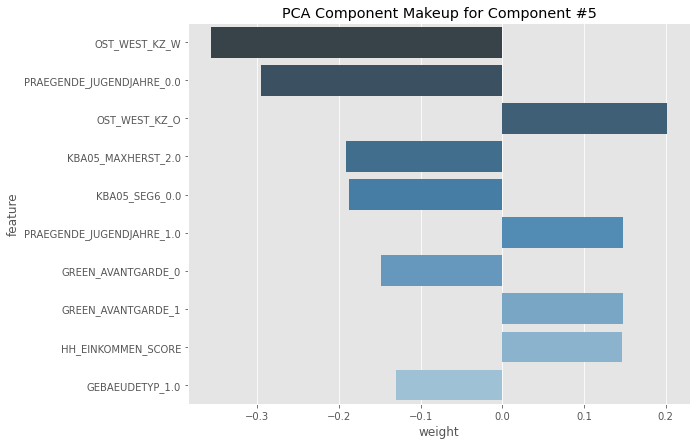

In [54]:
num = 5
display_component(w_df, features_list, num, n_weights=10)

In [55]:
# transform germany and customer data
germany_pca_data = pca.transform(imputed_g)
customer_pca_data = pca.transform(imputed_c)
train_pca = pca.transform(imputed_train)
test_pca = pca.transform(imputed_test)

In [89]:
germany_pca_data.shape

(891221, 200)

In [63]:
obs = len(germany_pca_data)
#distances = []
for k in range(15, 20):
    print('k = {}'.format(k))
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(germany_pca_data)
    distances.append(kmeans.inertia_/obs)

k = 15
k = 16
k = 17
k = 18
k = 19


In [65]:
len(distances)

19

Text(0.5, 1.0, 'Elbow curve')

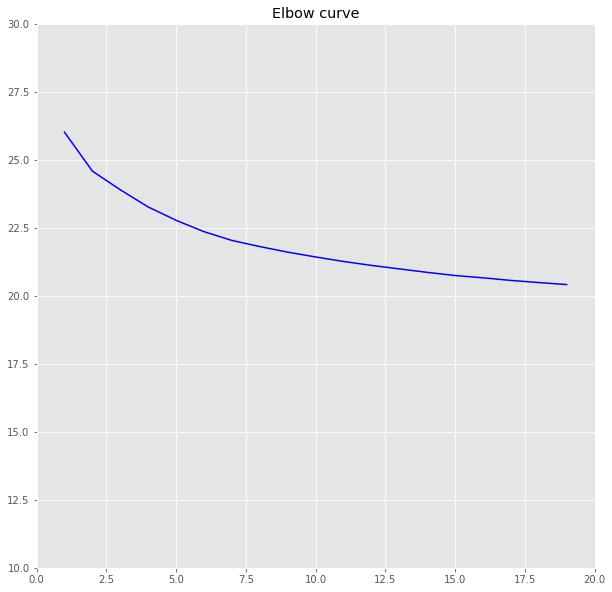

In [66]:
fig = plt.figure(figsize=(10, 10))
plt.plot(range(1,20), distances, color='blue')
plt.xlim(0, 20)
plt.ylim(10,30)
plt.grid(True)
plt.title('Elbow curve')

In [81]:
k = 7
kmeans = KMeans(n_clusters=k)
kmeans.fit(germany_pca_data)

KMeans(n_clusters=7)

In [82]:
germany_pred = kmeans.predict(germany_pca_data)
customer_pred = kmeans.predict(customer_pca_data)
g_len = len(germany_pred)
c_len = len(customer_pred)

In [83]:
germany_pred_df = pd.DataFrame(germany_pred)
germany_values = germany_pred_df[0].value_counts().sort_index()
customer_pred_df = pd.DataFrame(customer_pred)
customer_values = customer_pred_df[0].value_counts().sort_index()

In [84]:
germany_pred_df.head()

,0
0,4
1,2
2,0
3,1
4,3


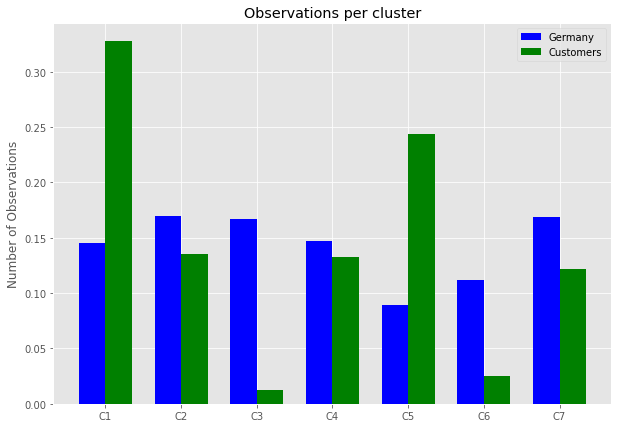

In [85]:
x = np.arange(k)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - width/2, germany_values.values/g_len, width, label='Germany', color='blue')
rects2 = ax.bar(x + width/2, customer_values.values/c_len, width, label='Customers', color='green')

# Add some text for labels, title and custom x-axis tick labels, etc.
labels = ['C{}'.format(ix + 1) for ix in np.arange(k)]
ax.set_ylabel('Number of Observations')
ax.set_title('Observations per cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

In [86]:
kmeans_df = pd.DataFrame(kmeans.cluster_centers_, columns = ['comp_{}'.format(i) for i in range(1,201)])
kmeans_df

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,...,comp_191,comp_192,comp_193,comp_194,comp_195,comp_196,comp_197,comp_198,comp_199,comp_200
0,1.730745,0.945027,-0.155194,0.438351,0.142512,0.508874,0.531029,-0.011459,0.045344,0.488809,...,-0.007091,-0.002614,0.000216,0.004292,0.002165,-0.003279,-0.002053,0.009424,0.003089,-0.001311
1,0.620347,-0.145328,-0.671936,-0.051986,-0.638438,-0.774731,-0.094128,0.148151,0.043570,-0.172654,...,0.005788,0.000889,0.003045,-0.002745,-0.003960,-0.000998,0.000244,-0.002866,0.003324,0.001876
2,-1.236034,0.154196,1.130464,0.003431,-0.053268,-0.417896,0.290235,0.204370,-0.103879,0.157245,...,-0.001990,0.001639,-0.001551,0.001410,-0.001630,-0.006484,0.000314,0.002979,-0.005321,-0.004052
3,1.427378,-0.973308,0.857252,-0.218334,0.588280,-0.062966,-0.324244,-0.126533,-0.113583,-0.217573,...,-0.000640,0.001115,0.000676,-0.005559,0.003062,0.003790,0.000447,-0.009664,-0.000065,0.000832
4,-0.636211,0.632520,0.047300,-1.485468,-1.306903,1.169411,-0.445847,-0.686402,-0.210168,-0.124081,...,0.004513,-0.004046,0.003970,0.007038,-0.003517,0.006844,0.001316,-0.001013,-0.004671,-0.004000
5,-1.126568,-1.483509,-0.746212,0.205088,0.224145,0.835962,0.086758,0.527378,0.500446,-0.019414,...,-0.000237,-0.004300,0.001913,-0.004481,-0.002366,-0.002081,0.002855,0.002705,0.005247,0.008216
6,-1.045978,0.674438,-0.585460,0.513575,0.604617,-0.368050,-0.189144,-0.216776,-0.101886,-0.135418,...,0.000585,0.003770,-0.005673,0.001734,0.004499,0.004696,-0.001769,-0.001045,-0.001680,-0.000798


Text(0.5, 1.0, 'Cluster Makeup')

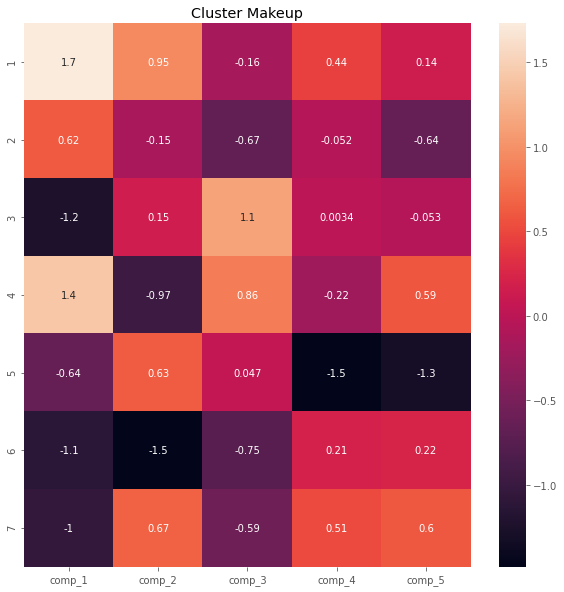

In [87]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(kmeans_df.iloc[0:13, 0:5], annot=True)
#sns.heatmap(kmeans_df, annot=True)
ax.set_yticklabels(np.arange(1,14))
plt.title('Cluster Makeup')

In [107]:
kmeans.predict(train_pca).shape

(42962,)

# Creating a feature for prediction


In [132]:
train_cluster_df = pd.DataFrame(kmeans.predict(train_pca), columns=['cluster'], index=X_total_train.index)
test_cluster_df = pd.DataFrame(kmeans.predict(test_pca), columns=['cluster'], index=X_test.index)

In [133]:
train_cluster_df['cluster'].value_counts()

0    9874
6    8425
4    7013
1    6624
3    5807
5    4631
2     588
Name: cluster, dtype: int64

In [134]:
train_cluster_df['cluster'] = train_cluster_df['cluster'].replace(0, 4)
train_cluster_df['cluster'] = train_cluster_df['cluster'].replace(1, 0)
train_cluster_df['cluster'] = train_cluster_df['cluster'].replace(2, 0)
train_cluster_df['cluster'] = train_cluster_df['cluster'].replace(3, 0)
train_cluster_df['cluster'] = train_cluster_df['cluster'].replace(5, 0)
train_cluster_df['cluster'] = train_cluster_df['cluster'].replace(6, 0)


train_cluster_df['cluster'] = train_cluster_df['cluster'].replace(4, 1)

In [135]:
train_cluster_df['cluster'].value_counts()

0    26075
1    16887
Name: cluster, dtype: int64

In [136]:
test_cluster_df['cluster'].value_counts()

0    9801
6    8461
4    6936
1    6564
3    5845
5    4680
2     546
Name: cluster, dtype: int64

In [137]:
test_cluster_df['cluster'] = test_cluster_df['cluster'].replace(0, 4)
test_cluster_df['cluster'] = test_cluster_df['cluster'].replace(1, 0)
test_cluster_df['cluster'] = test_cluster_df['cluster'].replace(2, 0)
test_cluster_df['cluster'] = test_cluster_df['cluster'].replace(3, 0)
test_cluster_df['cluster'] = test_cluster_df['cluster'].replace(5, 0)
test_cluster_df['cluster'] = test_cluster_df['cluster'].replace(6, 0)


test_cluster_df['cluster'] = test_cluster_df['cluster'].replace(4, 1)

In [138]:
test_cluster_df['cluster'].value_counts()

0    26096
1    16737
Name: cluster, dtype: int64

In [139]:
print(train_cluster_df.shape)
print(test_cluster_df.shape)

(42962, 1)
(42833, 1)


In [140]:
train_cluster_df.to_csv('experimentation/train_cluster_1_or_5.csv')
train_cluster_df.to_csv('experimentation/test_cluster_1_or_5.csv')